# Рекомендательные системы

In [ ]:
import logging
import os
import shutil 

import numpy as np
from google.colab import drive

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  # гарантируем воспроизводимость

logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info('Инициализировали логгер')

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)
logger.info('Подключили диск')

root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021')
if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  logger.info('Содержимое директории %s: %s', root_data_dir, os.listdir(root_data_dir))

2022-05-17 08:11:25,160 : Инициализировали логгер
2022-05-17 08:11:52,229 : Подключили диск
2022-05-17 08:11:52,244 : Содержимое директории /content/drive/MyDrive/hse_nlp_2021: ['corpora', 'nltk_data_old', 'nltk_data', '1000k_memes_ocr.tar.gz', 'logs', 'sklearn_data', 'nyt-ingredients-snapshot-2015.csv', 'insurance.csv', 'non_linear.csv', 'clustering.pkl', 'client_segmentation.csv', 'eigen.pkl', 'my_little_recsys', 'optimal_push_time', 'boosting_toy_dataset.csv', 'memes', 'torch_models', 'ocr_dataset.zip', 'final_dataset.zip', 'politic_meme.jpg', 'gray_goose.jpg', 'recsys_data']


Mounted at /content/drive


Датасет для обучения рекомендательных систем содержит следующие данные

* csv `user_item_views.zip` на ~2 млн строк вида

| user_id | item_id	| show_timestamp | show_duration |
| --- | --- | --- | --- |
| 912948920 | 1587935070 | 1119307 | 323 |

* архив `data/content_catalog.zip` содержит csv с названиями контента в формате

| item_id | title |
| --- | --- |
| 1593139110 | Тачки 3 |

* архив `data/json_views.tar.gz` содержит single-line JSON вида

```json
{"value": 6127, "date": 1606254752, "validation": 0, "item_id": 930420160, "user_id": 399644822}
```

* pickle `ground_truth_dataset.pkl` с просмотрами контента за 1 день по 13353 пользователям
* pickle `test_dataset.pkl` с просмотрами контента за 180 предшествующих дней по 13353 пользователям

Бинарный файл `ground_truth_dataset.pkl` это массив где каждый элемент представляет собой
записи из `json_views.tar.gz` агрегированные по полю `user_id` в словарь вида `{item_id: value, ..., item_id: value}`,
с флагом `is_validation=1` 

В файле `test_dataset.pkl` содержатся такие же записи, но с флагом `is_validation=0`.

Загружаем табличные данные для подсчёта статистик

In [ ]:
import pandas as pd

recsys_dir = os.path.join(root_data_dir, 'recsys_data')
user_item_data_file_path = os.path.join(recsys_dir, 'user_item_views.zip')

user_item_views_df = pd.read_csv(user_item_data_file_path, compression='zip')
logger.info('num rows: %d', user_item_views_df.shape[0])
user_item_views_df.head(3)

2022-05-17 08:14:00,633 : NumExpr defaulting to 2 threads.
2022-05-17 08:14:04,077 : num rows: 1975696


,user_id,item_id,show_timestamp,show_duration
0,912948920,1587935070,1119307,323
1,1882728205,1466874188,1115796,1428
2,382105433,276839040,1116585,921


Каталог контента

In [ ]:
catalog_file_path = os.path.join(recsys_dir, 'content_catalog.zip')
content_catalog = pd.read_csv(catalog_file_path, compression='zip')

content_catalog.head(5)

,item_id,title
0,448991742,Кэндимен
1,1131986063,Горячие головы
2,1835073733,После дождичка в четверг
3,1792204487,Сокровища О.К.
4,5589796,Затура: Космическое приключение


Тестовый и валидационный наборы данных

In [ ]:
import pickle

with open(os.path.join(recsys_dir, 'ground_truth_dataset.pkl'), 'rb') as f:
    ground_truth_dataset = pickle.load(f)
with open(os.path.join(recsys_dir, 'test_dataset.pkl'), 'rb') as f:
    test_dataset = pickle.load(f)
logger.info(
    'test dataset users %d, valid dataset users %d',
    len(test_dataset), len(ground_truth_dataset)
)

2022-05-17 08:14:44,208 : test dataset users 13163, valid dataset users 13163


Алгоритмы рекомендательных систем работают с матрицей user-item
* число строк совпадает с количеством пользователей
* число столбцов совпадает с количестовом контента
* на пересечении строки и столбца стоит единица в случае, если просмотр присутствовал в датасете и ноль если такого просмотра не было

Т.к. контента в системе намного больше, чем может посмотреть пользователь, то такая матрица называется разреженной (мы встречали такую в занятии по tf-idf)

Для трансформации в csr нужно перевести `user_id` в индекс строки, а `content_id` в индекс столбца. Создаём индексы

In [ ]:
unique_users = user_item_views_df.user_id.unique()
unique_items = user_item_views_df.item_id.unique()

# премая и обратная индексация контента
item_to_id = {j: i for i, j in enumerate(unique_items)}
id_to_item = {j: i for i, j in item_to_id.items()}

# прямая и обратная индексация пользователей
user_to_id = {j: i for i, j in enumerate(unique_users)}
logger.info('Индекс создан: %d строк %d столбцов', len(user_to_id), len(item_to_id))

2022-05-17 08:17:25,825 : Индекс создан: 168756 строк 9991 столбцов


## Трансформация в csr

Для каждого пользователя оставляем top-20 последних просмотров чтобы матрица не получилась сишком большой

In [ ]:
HISTORY_TOP = 20
# применяем оконную функцию
user_item_views_df['rank'] = (
    user_item_views_df
    .groupby(by=['user_id'])['show_timestamp']
    .rank(method='first', ascending=False)
)
ui_slim_df = (
    user_item_views_df[user_item_views_df['rank'] < HISTORY_TOP][['user_id', 'item_id']]
)

ui_slim_df.head()

,user_id,item_id
0,912948920,1587935070
1,1882728205,1466874188
2,382105433,276839040
3,1030600713,401051817
4,743755331,1193027362


Создаём матрицу

In [ ]:
from scipy.sparse import csr_matrix

num_rows = len(user_to_id)
num_cols = len(item_to_id)
entries = np.ones(ui_slim_df.shape[0])  # проставляем ненулевые элементы - единицы
rows = tuple(user_to_id[i] for i in ui_slim_df.user_id.values)
cols = tuple(item_to_id[i] for i in ui_slim_df.item_id.values)

train_set_csr = csr_matrix(
    (entries, (rows, cols)),
    shape=(num_rows, num_cols),
    dtype=np.float32
)
train_set_csr

<168756x9991 sparse matrix of type '<class 'numpy.float32'>'
	with 1433407 stored elements in Compressed Sparse Row format>

Обучение модели

In [ ]:
# !pip install implicit==0.5.2

from implicit.als import AlternatingLeastSquares

implict_als_params = {'factors': 4, 'iterations': 1}
model = AlternatingLeastSquares(**implict_als_params)
# на вход подаём матрицу user_item
model.fit(train_set_csr)

  0%|          | 0/1 [00:00<?, ?it/s]

Пример работы модели достаём историю просмотров случайного пользователя

На вход ALS идёт CSR матрица с просмотренным контентом, по которой генерируются рекомендации

In [ ]:
def id_to_content_df(ids: np.array, content_df: pd.DataFrame, id_to_item):
    items = tuple(id_to_item[i] for i in ids)
    result_df = content_catalog[
        content_catalog.item_id.isin(items)
    ]
    return result_df

# csr матрица на вход ALS
random_history = train_set_csr[np.random.randint(low=0, high=train_set_csr.shape[0])]
id_to_content_df(random_history.nonzero()[1], content_catalog, id_to_item)

,item_id,title
1148,1965687007,Война миров Z
5640,733867875,Союзники
7103,997565431,Ной
10880,1323560630,Zомбилэнд: Контрольный выстрел
11139,1502288546,Мумия
12108,1095953790,Бронкская история
13091,997620418,Семь психопатов
16232,1141280972,Спящие
26665,1148282040,Просто помиловать
27072,267109624,Хозяин морей: На краю Земли


Приверим, что рекомендует модель для такой истории просмотров

In [ ]:
recommended_content, recommended_scores = model.recommend(
            userid = 0,
            user_items=random_history,
            N=10,
            filter_already_liked_items=True,
            recalculate_user=True
)
id_to_content_df(recommended_content, content_catalog, id_to_item)

,item_id,title
1027,1507021169,Тайная жизнь домашних животных 2
1996,777155690,Холодное сердце 2
6380,454621642,Один дома
6631,600517301,Зов предков
10630,784227936,Эверест
11550,1123282289,После. Глава 2
15814,714521811,Моана
27442,157249585,Капоне. Лицо со шрамом
28796,538560695,Разговорник
30121,231135289,"Гудбай, Америка"


Готовим валидационный и тестовый сет

In [ ]:
from typing import Dict
from multiprocessing import Pool

NUM_PROCESSES = 2

def get_als_action_history_vector(item_to_id: Dict[int, int], action_history, binary=True) -> np.ndarray:
    """Получить историю действий для ALS

    :param item_to_id: справочник контента ALS
    :return:
    """
    als_action_history_vector = np.zeros(len(item_to_id), dtype=int)
    for iid, item_attr in action_history.items():
        if iid in item_to_id.keys():
            if binary:
                als_action_history_vector[item_to_id[iid]] = 1
            else:
                als_action_history_vector[item_to_id[iid]] = item_attr
    return als_action_history_vector

def vectorize_action_history(action_history):
    res = get_als_action_history_vector(item_to_id, action_history)
    return res

logger.info('data preparing started...')
with Pool(NUM_PROCESSES) as p:
    # персональная история просмотров
    test_dataset_vectors = p.map(vectorize_action_history, test_dataset)
    # валидация
    ground_truth_dataset_vectors = p.map(vectorize_action_history, ground_truth_dataset)
logger.info('test dataset length: %d', len(test_dataset_vectors))

2022-05-17 08:22:51,942 : data preparing started...
2022-05-17 08:22:59,331 : test dataset length: 13163


Объединяем историю пользователя и валидационный сет

In [ ]:
train_valid_pairs = []
for test_user_id in range(len(test_dataset_vectors)):
    train_valid_pairs.append((
        csr_matrix(test_dataset_vectors[test_user_id]),  # csr матрица на вход ALS
        ground_truth_dataset_vectors[test_user_id].nonzero()[0]
    ))
logger.info('validation prepared')

2022-05-17 08:23:40,894 : validation prepared


## Бейзлайны

Рандомные рекомендации

In [ ]:
N = 50
content_popularity = np.asarray(train_set_csr.sum(axis=0)).reshape(-1)
all_content = np.array(list(id_to_item.keys()))

def top_n_recommends_random(watch_history):
    top_n_result = np.random.choice(all_content, size=N, replace=True)
    hit = 0
    if len(watch_history[1]) > 0 and np.intersect1d(watch_history[1], top_n_result).size > 0:
        hit = 1
    return hit

with Pool(NUM_PROCESSES) as p:
    hits = p.map(top_n_recommends_random, train_valid_pairs)
logger.info('Num hits %.4f from %d', sum(hits)/len(hits), len(hits))

2022-05-17 08:25:15,152 : Num hits 0.0093 from 13163


Если делать предсказания рандомно, угадываем всего в 1% случаев

# Неперсональные рекомендации: популярность

Что будет, если рекомендовать популярный контент (всем один и тот же список)

In [ ]:
N = 40
content_popularity = np.asarray(train_set_csr.sum(axis=0)).reshape(-1)
top_100_popular_items = np.argsort(-content_popularity)[:100]

def top_n_recommends_popular(watch_history):
    top_n_result = top_100_popular_items[:N]
    hit = 0
    if len(watch_history[1]) > 0 and np.intersect1d(watch_history[1], top_n_result).size > 0:
        hit = 1
    return hit

with Pool(5) as p:
    hits = p.map(top_n_recommends_popular, train_valid_pairs)

logger.info('Num hits %.4f from %d', sum(hits)/len(hits), len(hits))

2022-05-17 08:26:36,545 : Num hits 0.1844 from 13163


Видим рост качества, популярность - мощный бейзлайн

## Персональные рекомедации

Наконец, воспользуемся ALS. Обучим модель

In [ ]:
implict_als_params = {'factors': 20, 'iterations': 30}
model = AlternatingLeastSquares(**implict_als_params)
logger.info('train started')
model.fit(train_set_csr)
logger.info('train finished')

2022-05-17 08:26:45,078 : train started


  0%|          | 0/30 [00:00<?, ?it/s]

2022-05-17 08:29:48,221 : train finished


Персональные рекомендации

In [ ]:
from tqdm import tqdm

N = 50
testing_model = model

def top_n_recommends_personal(watch_history):
    top_n_result, recommended_scores = testing_model.recommend(
            userid = 0,
            user_items=watch_history[0],
            N=N,
            filter_already_liked_items=True,
            recalculate_user=True
    )
    hit = 0
    if len(watch_history[1]) > 0 and np.intersect1d(watch_history[1], top_n_result).size > 0:
        hit = 1
    return hit

NUM_PROCESSES = 2
logger.info('Prediction started')
# with Pool(NUM_PROCESSES) as p:
#     hits = p.map(top_n_recommends_personal, train_valid_pairs[:10])
hits = [top_n_recommends_personal(i) for i in train_valid_pairs]
logger.info('Num hits %.4f from %d', sum(hits)/len(hits), len(hits))

2022-05-17 08:29:48,286 : Prediction started
2022-05-17 08:33:13,531 : Num hits 0.2581 from 13163


In [ ]:
testing_model.item_factors.shape

(9991, 20)

In [ ]:
testing_model.user_factors.shape

(168756, 20)

In [ ]:
from numpy import save, load

item_factors_file_path = os.path.join(recsys_dir, 'item_factors.zip')

# save(item_factors_file_path, testing_model.item_factors)
# logger.info('saved to %s', item_factors_file_path)

# item_factors = load(item_factors_file_path)
# logger.info('saved to %s', item_factors_file_path)

Чтобы как-то проверить качество полученных эмбеддингов, визуализируем их с помощью UMAP

In [ ]:
# !pip install umap-learn

from umap import UMAP

logger.info('umap started...')
manifold = UMAP(random_state=RANDOM_SEED, n_components=2).fit(testing_model.item_factors)
X_umap = manifold.transform(testing_model.item_factors)
logger.info('umap finished...')

2022-04-10 14:42:22,279 : umap started...
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-10 14:43:20,174 : umap finished...


К сожалению, визуально кластера не отделяются

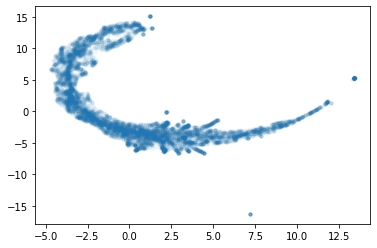

In [ ]:
from matplotlib import pyplot as plt

plt.scatter(X_umap[:,0], X_umap[:,1], s=10, alpha=0.05)
plt.show()

Попробуем прогнать через DBSCAN

2022-04-10 15:05:24,549 : [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


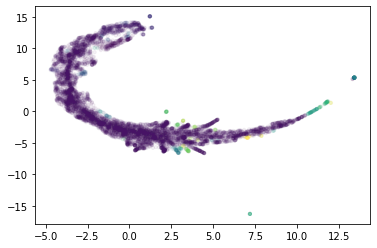

In [ ]:
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.15, min_samples=5, leaf_size=10).fit(X_umap)
logger.info('Число кластеров: %d', len(np.unique(clustering.labels_)))
plt.scatter(X_umap[:,0], X_umap[:,1], s=10, alpha=0.05, c=clustering.labels_)
plt.show()

Особо ничего не вышло(